<b><u>Problem Description</b> : Health insurance is like a backbone to the citizens of a country that deals with
many hardships along with uncertainty in their health condition. To contract the burden of paying huge
medical bills governments as well as private insurance companies provide health insurance schemes on
some premiums to be paid in installments.
One of the most important problems in the insurance industry is fraud in claims which causes substantial
losses to the insurance providers..The cost of determining or predicting potential fraud in any claim
submitted is very high because if it is done incorrectly it may irritate legitimate customers and it may result in
delayed claims adjudication.Healthcare fraud is an organized crime which involves peers of providers,
physicians, beneficiaries acting together to make fraud claims.Provider Fraud is one of the biggest problems
facing Medicare. For example an uninsured person may unlawfully get insurance benefits disguising himself
as an insured person, or some provider may wrongly put an exaggerated amount on a member's bill later to
be settled with the insurance provider.


<b><u>Problem Statement</b> :
<ul>
<li>Predict the probability that a provider is potential fraud and flag them accordingly.</li>
<li>Discover important variables that might be helpful in flagging providers as potential fraud.</li>
</ul>


<b><u>Business constraints</b>:
<ul>
<li>Cost of misclassification is very high.</li>
<li>No strict latency requirements.</li>
<li>Model interpretability is very important.</li>
</ul>

<b><u>Data </b>: 
We have 4 csv files for training/testing purposes.These data files are procured from kaggle. These files
contain viable information of the insurance scheme beneficiaries,patients who got admitted in the hospital
and undergone some medical procedure and diagnosis(inpatient data),patients who visited hospital for
some procedure or diagnosis or both but were not admitted(outpatient) and medical service providers
who are labelled as potential fraud or not.


<b><u>Machine Learning Problem</b>: 

This is a binary classification problem,for a given set of features we
need to predict whether the corresponding provider needs to be flagged as potential fraud or not.


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from tqdm.notebook import trange, tqdm
import joblib
import os
from sklearn.preprocessing import Normalizer , StandardScaler

# Function 1
### Complete pipeline to take raw csv file and return predicted values

In [39]:
X = {'Inpatient_data_csv_file':'Test_Inpatientdata-1542969243754.csv',
    'Outpatient_data_csv_file':'Test_Outpatientdata-1542969243754.csv',
    'Beneficiary_data_csv_file':'Test_Beneficiarydata-1542969243754.csv',
    'Test_provider_ID_csv_file': 'Test-1542969243754.csv'}

In [106]:
def Predict_Fraud_providers(X):
    
    '''This function takes Inpatient,outpatient,Beneficiary and Provider Id in respective raw CSV file and flags predicted
    fradulent providers'''
    
    if not os.path.isfile('final_test_data.csv'):
        
        print('Merging all raw data files together........')
    
        #read all input data 
        inpatient = pd.read_csv(X['Inpatient_data_csv_file'])
        outpatient = pd.read_csv(X['Outpatient_data_csv_file'])
        beneficiary = pd.read_csv(X['Beneficiary_data_csv_file'])
        Test_provider_ID = pd.read_csv(X['Test_provider_ID_csv_file'])
    
        #merging all raw data into one dataframe
        inpatient['is_admitted'] = 1
        outpatient['is_admitted'] = 0

        # Merge in_pt, out_pt and ben df into a single patient dataset
        merged_data = pd.merge(inpatient, outpatient,
                        left_on = [ idx for idx in outpatient.columns if idx in inpatient.columns],
                        right_on = [ idx for idx in outpatient.columns if idx in inpatient.columns],
                        how = 'outer').\
              merge(beneficiary,left_on='BeneID',right_on='BeneID',how='inner')
        
        print('Merging of raw data files Done !')
        print('')
        print('==================================================================================================')
        print('Start Data perocessing......')
        
        #perprocessing : 
        # Replace values with a binary annotation
        merged_data = merged_data.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
                  0)
    
        # Replace values with a binary annotation
        merged_data = merged_data.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})
        #merging the dataset created in above step with target_data
        merged_data = pd.merge(merged_data, Test_provider_ID , how = 'outer', on = 'Provider' )

    
        #Adding a column is_dead  = 1  DOD is given else is_dead = 0 
        merged_data.loc[merged_data['DOD'].isnull(), 'Is_Dead'] = '0'
        merged_data.loc[(merged_data['DOD'].notnull()), 'Is_Dead'] = '1'
    
        merged_data['DOB'] =  pd.to_datetime(merged_data['DOB'], format='%Y-%m-%d')  
        merged_data['ClaimStartDt'] = pd.to_datetime(merged_data['ClaimStartDt'], format='%Y-%m-%d')  

        #now = pd.to_datetime('2020-09-01' , format = '%Y-%m-%d')
        merged_data['DOB'] = merged_data['DOB'].where(merged_data['DOB'] < merged_data['ClaimStartDt']) 
        merged_data['age'] = (merged_data['ClaimStartDt'] - merged_data['DOB']).astype('<m8[Y]')
    
        merged_data = merged_data.drop(['DOD'], axis = 1)
        merged_data = merged_data.drop(['DOB'], axis = 1)
    
        merged_data['AdmissionDt'] = pd.to_datetime(merged_data['AdmissionDt'] , format = '%Y-%m-%d')
        merged_data['DischargeDt'] = pd.to_datetime(merged_data['DischargeDt'],format = '%Y-%m-%d')
        merged_data['Num_admit_days'] = ((merged_data['DischargeDt'] - merged_data['AdmissionDt']).dt.days)+1
        merged_data.loc[merged_data['is_admitted'] == 0, 'Num_admit_days'] = '0'

        merged_data = merged_data.drop(['DischargeDt'], axis = 1)
        merged_data = merged_data.drop(['AdmissionDt'], axis = 1)
    
        #repalcing NaN value with 0
        merged_data.loc[merged_data['DeductibleAmtPaid'].isnull(),'DeductibleAmtPaid'] = 0
    
        Diag_proce_col = ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
                      'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                      'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
                      'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
                      'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
                      'ClmProcedureCode_5', 'ClmProcedureCode_6']

        merged_data[Diag_proce_col]= merged_data[Diag_proce_col].replace({np.nan:0})
    
    
        def encoded_cat(dataset, feature_to_encode='',col_list=[]):
            """This function returns top 5 cat column useful in determining potential fraud"""
            outer_list =[]
            for col in col_list:
                list_1 = list()
        
                for item in list(dataset[col]):
                    if str(item) == str(feature_to_encode):
                        list_1.append(1)
                    else:
                        list_1.append(0)
        
                outer_list.append(list_1)
    
            li_sum = np.array([0]*merged_data.shape[0])
    
            for i in range(0,len(outer_list)):
                li1 = np.array(outer_list[i])
                li_sum = li_sum + li1
        
            return li_sum


        procedure_col = ['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']
   
        diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']


        #top 5 procedure
        # 4019.0, 2724.0, 9904.0, 8154.0, 66.0
        merged_data['pr_4019'] = encoded_cat(merged_data,'4019.0',procedure_col)
        merged_data['pr_2724'] = encoded_cat(merged_data,'2724.0',procedure_col)
        merged_data['pr_9904'] = encoded_cat(merged_data,'9904.0',procedure_col)
        merged_data['pr_8154'] = encoded_cat(merged_data,'8154.0',procedure_col)
        merged_data['pr_66'] =   encoded_cat(merged_data,'66.0',procedure_col)

        #top 5 diagnosis 
        #4019,25000,2724,V5869,42731
        merged_data['di_4019'] = encoded_cat(merged_data,'4019',diagnosis_col)
        merged_data['di_25000'] = encoded_cat(merged_data,'25000',diagnosis_col)
        merged_data['di_2724'] = encoded_cat(merged_data,'2724',diagnosis_col)
        merged_data['di_V5869'] = encoded_cat(merged_data,'V5869',diagnosis_col)
        merged_data['di_42731'] =   encoded_cat(merged_data,'42731',diagnosis_col)
    
        for i in Diag_proce_col:
            merged_data[i][merged_data[i]!=0]= 1
        
        merged_data[Diag_proce_col]= merged_data[Diag_proce_col].astype(float)
        '''---------------------------------------------------------------------------------------------------------------'''
        #adding column total_num_diag
        merged_data['total_num_diag'] = 0 
        for col in diagnosis_col :
            merged_data['total_num_diag']  = merged_data['total_num_diag'] + merged_data[col]
        #print(merged_data.shape)
        
        #adding column total_num_proce
        merged_data['total_num_proce'] = 0 
        for col in procedure_col :
            merged_data['total_num_proce']  = merged_data['total_num_proce'] + merged_data[col]
        
        merged_data['total_num_diag'] =  merged_data['total_num_diag'].astype(float)
        merged_data['total_num_proce'] =  merged_data['total_num_proce'].astype(float)
        #print(merged_data.shape)
        '''---------------------------------------------------------------------------------------------------------------'''
    
        val_counts_ = merged_data['BeneID'].value_counts()
        tr_data_final_beneid_df = val_counts_.to_frame() #store this information in dataframe

        tr_data_final_beneid_df.columns = ['count'] 
        tr_data_final_beneid_df['BeneID'] = tr_data_final_beneid_df.index
        
        total_amt_list = []
        mean_amt_list = []

        for benid in tqdm(tr_data_final_beneid_df['BeneID']):
    
            total_amt = merged_data.loc[merged_data['BeneID'] == benid,'InscClaimAmtReimbursed'].sum() 
            mean_amt = total_amt / (tr_data_final_beneid_df.loc[tr_data_final_beneid_df['BeneID'] == benid,'count'])
    
            total_amt_list.append(total_amt)
            mean_amt_list.append(mean_amt)
    
        mean_list = []
        for item in tqdm(mean_amt_list):
            mean_list.append(item[0])

        
        tr_data_final_beneid_df['mean_InscClaimAmtReimbursed']=mean_list
        tr_data_final_beneid_df['total_InscClaimAmtReimbursed']=total_amt_list
        
    
        merged_data = pd.merge(merged_data, tr_data_final_beneid_df, how='outer', on='BeneID')
        merged_data[['mean_InscClaimAmtReimbursed','total_InscClaimAmtReimbursed']]= merged_data[['mean_InscClaimAmtReimbursed','total_InscClaimAmtReimbursed']].astype(float)
                
        '''---------------------------------------------------------------------------------------------------------------'''

        
        def N_unique_values(df):
            """This function finds the unique values in a df row"""
            return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])
        
        #number of unique physicians for each patient
        merged_data['N_unique_Physicians'] = N_unique_values(merged_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 

        #encoding types of physicians into numeric values
        merged_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(merged_data[['AttendingPhysician','OperatingPhysician',
                                                                                      'OtherPhysician']].isnull(), 0, 1)

        # number of different physicians who attend a patient
        merged_data['N_Types_Physicians'] = merged_data['AttendingPhysician'] + merged_data['OperatingPhysician'] + merged_data['OtherPhysician']

        # patients who was attended by only 1 physicians
        merged_data['Same_Physician'] = merged_data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 1 and x['N_Types_Physicians'] > 1) else 0,axis=1)

        #determine if 1 physician has multi[le role to attend a patient
        merged_data['Same_Physician2'] = merged_data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 2 and x['N_Types_Physicians'] > 2) else 0,axis=1)
        
        merged_data['DiagnosisGroupCode']= merged_data['DiagnosisGroupCode'].replace({np.nan:0})
        
        print('Data processing Done !')
        
        merged_data.to_csv('final_test_data.csv',index= False)
        print('Final Test dataset shape : ',merged_data.shape)
        
    
    else: 
        merged_data = pd.read_csv('final_test_data.csv')
        print('Final Test dataset shape : ',merged_data.shape)
     
    
    
    col_to_remove = ['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',\
                 'OperatingPhysician', 'OtherPhysician','ClmAdmitDiagnosisCode','NoOfMonths_PartACov',\
                 'NoOfMonths_PartBCov','DiagnosisGroupCode']
    
    merged_data.drop(columns=col_to_remove, axis=1, inplace=True)

    
    Provider_ID = merged_data['Provider'].values
    merged_data.drop(columns='Provider', axis=1, inplace=True)
    
    def num_col_normalizer(X,col=''):
        """This function retruns normalised column for train and test data"""
        normalizer = Normalizer()
    
        normalizer.fit(X[col].values.reshape(1,-1))
        X_norm = normalizer.transform(X[col].values.reshape(1,-1)).reshape(-1,1)
        return X_norm
        
    
    #InscClaimAmtReimbursed
    X_norm = num_col_normalizer(merged_data ,col='InscClaimAmtReimbursed')
    merged_data['InscClaimAmtReimbursed'] = X_norm

    X_norm = num_col_normalizer(merged_data ,col='DeductibleAmtPaid')
    merged_data['DeductibleAmtPaid'] = X_norm
   
    X_norm = num_col_normalizer(merged_data, col='IPAnnualReimbursementAmt')
    merged_data['IPAnnualReimbursementAmt'] = X_norm

    X_norm = num_col_normalizer(merged_data ,col='IPAnnualDeductibleAmt')
    merged_data['IPAnnualDeductibleAmt'] = X_norm
 
    X_norm = num_col_normalizer(merged_data ,col='OPAnnualReimbursementAmt')
    merged_data['OPAnnualReimbursementAmt'] = X_norm

    X_norm = num_col_normalizer(merged_data ,col='OPAnnualDeductibleAmt')
    merged_data['OPAnnualDeductibleAmt'] = X_norm
  
    X_norm = num_col_normalizer(merged_data ,col='mean_InscClaimAmtReimbursed')
    merged_data['mean_InscClaimAmtReimbursed'] = X_norm

    X_norm = num_col_normalizer(merged_data ,col='total_InscClaimAmtReimbursed')
    merged_data['total_InscClaimAmtReimbursed'] = X_norm

    X_norm = num_col_normalizer(merged_data ,col='age')
    merged_data['age'] = X_norm
  
    X_norm = num_col_normalizer(merged_data ,col='Num_admit_days')
    merged_data['Num_admit_days'] = X_norm
    
    X_norm = num_col_normalizer(merged_data ,col='N_unique_Physicians')
    merged_data['N_unique_Physicians'] = X_norm

    X_norm = num_col_normalizer(merged_data ,col='N_Types_Physicians')
    merged_data['N_Types_Physicians'] = X_norm
    
    '''--------------------------------------------------------------------------------------------------------------'''
    print('Final Test dataset shape after all preprocessing : ',merged_data.shape)
    #predicting
    
    input_data_list , target_list, selected_rows , selected_col = joblib.load('Sampling_data.pkl')
    model_list = joblib.load('model_list.pkl')
    
    #notation : mm --> meta_model
    def get_meta_model_test_data(mm_test_df,k):
        '''This fun returns dataset to check the performence the meta model'''

        mm_test_X= mm_test_df.values
    
        pred_all_base_models = []
    
        for i in range(0,k):
            y_pred = model_list[i].predict(mm_test_X[:,selected_col[i]])#prediction from each model
            pred_all_base_models.append(y_pred)
        
        mm_test_final_X = np.array(pred_all_base_models).transpose()#(rows = n, col = 30)
    
        return mm_test_final_X
    
    mm_x_test = get_meta_model_test_data(merged_data ,k=70)
    
    mm_LR = joblib.load('mm_logiistic_regression.pkl')
    
    def predict_with_best_t(proba, threshould):
        predictions = []
        for i in proba:
            if i>=threshould:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
    
    y_pred_prob = mm_LR.predict_proba(mm_x_test)[:,1]
    pred_output = predict_with_best_t(y_pred_prob, threshould = 0.362)
    
    #y_yred = mm_LR.predict(mm_x_test)
    print('')
    print('Predicting potential Fradulent Provider ........')
    prediction_df = pd.DataFrame()
    prediction_df['Provider_ID'] = Provider_ID
    prediction_df['prediction'] = pred_output
    
    return prediction_df
    

In [107]:
prediction_df= Predict_Fraud_providers(X)

print(prediction_df)

Final Test dataset shape :  (135392, 73)
Final Test dataset shape after all preprocessing :  (135392, 61)

Predicting potential Fradulent Provider ........
       Provider_ID  prediction
0         PRV57070           1
1         PRV56558           1
2         PRV57070           1
3         PRV56573           1
4         PRV56806           1
...            ...         ...
135387    PRV56372           0
135388    PRV54617           0
135389    PRV53736           0
135390    PRV53736           0
135391    PRV53089           1

[135392 rows x 2 columns]


In [110]:
prediction_df.head()

,Provider_ID,prediction
0,PRV57070,1
1,PRV56558,1
2,PRV57070,1
3,PRV56573,1
4,PRV56806,1


# Function 2
### Complete pipeline to take test data as inout and compare model performence

In [101]:
test_data = pd.read_csv('final_test_data_model_evaluation.csv')

y = test_data['target']
X = test_data.drop('target', axis=1)

def Result_evalutaion(X,y):
    '''This function takes features and and corrosponding Target value as input and performs model evaluation'''
    
    Provider_ID = X['Provider'].values
    X.drop(columns='Provider', axis=1, inplace=True)
    
    def num_col_normalizer(X,col=''):
       
        """This function retruns normalised column for train and test data"""
    
        normalizer = Normalizer()
        normalizer.fit(X[col].values.reshape(1,-1))
        X_norm = normalizer.transform(X[col].values.reshape(1,-1)).reshape(-1,1)
        return X_norm
        
    
    #InscClaimAmtReimbursed
    X_norm = num_col_normalizer(X ,col='InscClaimAmtReimbursed')
    X['InscClaimAmtReimbursed'] = X_norm

    X_norm = num_col_normalizer(X ,col='DeductibleAmtPaid')
    X['DeductibleAmtPaid'] = X_norm
   
    X_norm = num_col_normalizer(X, col='IPAnnualReimbursementAmt')
    X['IPAnnualReimbursementAmt'] = X_norm

    X_norm = num_col_normalizer(X ,col='IPAnnualDeductibleAmt')
    X['IPAnnualDeductibleAmt'] = X_norm
 
    X_norm = num_col_normalizer(X ,col='OPAnnualReimbursementAmt')
    X['OPAnnualReimbursementAmt'] = X_norm

    X_norm = num_col_normalizer(X ,col='OPAnnualDeductibleAmt')
    X['OPAnnualDeductibleAmt'] = X_norm
  
    X_norm = num_col_normalizer(X ,col='mean_InscClaimAmtReimbursed')
    X['mean_InscClaimAmtReimbursed'] = X_norm

    X_norm = num_col_normalizer(X ,col='total_InscClaimAmtReimbursed')
    X['total_InscClaimAmtReimbursed'] = X_norm

    X_norm = num_col_normalizer(X ,col='age')
    X['age'] = X_norm
  
    X_norm = num_col_normalizer(X ,col='Num_admit_days')
    X['Num_admit_days'] = X_norm
    
    X_norm = num_col_normalizer(X ,col='N_unique_Physicians')
    X['N_unique_Physicians'] = X_norm

    X_norm = num_col_normalizer(X ,col='N_Types_Physicians')
    X['N_Types_Physicians'] = X_norm
    
    '''--------------------------------------------------------------------------------------------------------------'''
    print('Final Test dataset shape : ',X.shape)
    #predicting
    
    input_data_list , target_list, selected_rows , selected_col = joblib.load('Sampling_data.pkl')
    model_list = joblib.load('model_list.pkl')
    
    #notation : mm --> meta_model
    def get_meta_model_test_data(mm_test_df,k):
        '''This fun returns dataset to check the performence the meta model'''

        mm_test_X= mm_test_df.values
    
        pred_all_base_models = []
    
        for i in range(0,k):
            y_pred = model_list[i].predict(mm_test_X[:,selected_col[i]])#prediction from each model
            pred_all_base_models.append(y_pred)
        
        mm_test_final_X = np.array(pred_all_base_models).transpose()#(rows = n, col = 30)
    
        return mm_test_final_X
    
    mm_x_test = get_meta_model_test_data(X ,k=70)
    
    mm_LR = joblib.load('mm_logiistic_regression.pkl')
    
    #pridicting Yq for given Xq with best threshold:
    def predict_with_best_t(proba, threshould):
        predictions = []
        for i in proba:
            if i>=threshould:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
    
    def get_confusion_matrix(y, y_pred, best_t = 0.362):
        cm = pd.DataFrame(confusion_matrix(y, predict_with_best_t(y_pred, best_t)))
        sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'])
    
    y_pred_prob = mm_LR.predict_proba(mm_x_test)[:,1]
    test_fpr, test_tpr, thresholds = roc_curve(y, y_pred_prob)

    pred_output = predict_with_best_t(y_pred_prob, threshould = 0.362)
    
    #test confusion matrix heatmap
    get_confusion_matrix(y, pred_output, best_t=0.362)
    plt.title("confusion matrix for test data")
    plt.show()
    
    actual_output = y
    model_f1_score = metrics.f1_score(actual_output,pred_output)
    print("Model test F1 score is : ",model_f1_score)
    
    model_AUC_score = metrics.auc(test_fpr, test_tpr)
    print("Model test AUC score is : ",model_AUC_score)
    
    print('')
    #y_pred = mm_LR.predict(mm_x_test)
    print('Predicting potential Fradulent Provider ........')
    prediction_df = pd.DataFrame()
    prediction_df['Provider_ID'] = Provider_ID
    prediction_df['prediction'] = pred_output
    prediction_df['true_target'] = y
    
    
    return prediction_df


Final Test dataset shape :  (111643, 61)


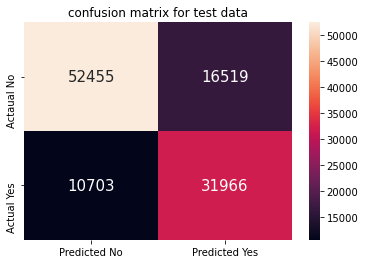

Model test F1 score is :  0.701362529345942
Model test AUC score is :  0.8121252680813508
/
Predicting potential Fradulent Provider ........
       Provider_ID  prediction  true_target
0         PRV57173           1            1
1         PRV57287           0            0
2         PRV57526           0            0
3         PRV55004           1            1
4         PRV54635           0            0
...            ...         ...          ...
111638    PRV56447           1            1
111639    PRV53928           0            0
111640    PRV52041           1            1
111641    PRV56228           0            0
111642    PRV55234           0            0

[111643 rows x 3 columns]


In [102]:
Result_evalutaion = Result_evalutaion(X,y)
print(Result_evalutaion)

In [103]:
Result_evalutaion.head()

,Provider_ID,prediction,true_target
0,PRV57173,1,1
1,PRV57287,0,0
2,PRV57526,0,0
3,PRV55004,1,1
4,PRV54635,0,0


In [104]:
Result_evalutaion.tail()

,Provider_ID,prediction,true_target
111638,PRV56447,1,1
111639,PRV53928,0,0
111640,PRV52041,1,1
111641,PRV56228,0,0
111642,PRV55234,0,0
